In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import os
import mat73
import scipy.io as spio
import scipy.stats as sp
import mat73
import seaborn as sns
from scipy.special import factorial
from scipy.special import logsumexp
import pandas as pd
from replay_structure.utils import get_marginal_sum

from scipy import stats

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# import numerical libraries
import numpy as np
import scipy.interpolate
import os
import pickle

# the data is stored in a HDF5 file
# so import the tools to load HDF5 files
import h5py

# import plotting tools and set up
# inline figures for the notebook
import matplotlib.pyplot as plt

%matplotlib inline

# the description of the maze is encoded in YAML
# so let's import tools to parse YAML
import yaml

# Fklab-python-core tool 
#-----------------------

# importing the shapes module is needed to extend the YAML parser
# so that it recognizes YAML representations of shapes
import fklab.geometry.shapes

# import utilities to work with time segments
import fklab.segments

# Py-compressed-kde package
# -------------------------

# finally, import the decoding tools
import compressed_kde
from compressed_kde import decode



# loading data

In [4]:
RESULTS_PATH = "/home/masha/Documents/Studium/MIT/project/data/y_maze/"
lp = mat73.loadmat(RESULTS_PATH+'linearPos.mat')
vel = mat73.loadmat(RESULTS_PATH+'linearVel.mat')
sp = mat73.loadmat(RESULTS_PATH+'spks.mat')
stim = mat73.loadmat(RESULTS_PATH+'stim.mat')

In [5]:
lp['lPos']['run3']

{'arm1': array([ True,  True,  True, ...,  True,  True,  True]),
 'arm2': array([False, False, False, ..., False, False, False]),
 'commonStem': array([False, False, False, ..., False, False, False]),
 'data': array([-145.06434308, -141.2411191 , -126.34697865, ..., -132.43580612,
        -145.06434308, -145.06434308]),
 'timestamp': array([11068.05441194, 11068.08820394, 11068.12097194, ...,
        11929.35309994, 11929.38586794, 11929.41965994])}

In [6]:
vel

{'lVel': {'run1': {'data': array([0., 0., 0., ..., 0., 0., 0.]),
   'timestamp': array([4130.39275   , 4130.46055594, 4130.49383594, ..., 4954.50509994,
          4954.53940394, 4954.57217194])},
  'run2': {'data': array([ 548.03008256,  540.76751879,  521.82524909, ..., -349.70956581,
          -301.3745463 , -245.24789121]),
   'timestamp': array([7433.883822  , 7433.917614  , 7433.950894  , ..., 8407.47303594,
          8407.50682794, 8407.53959594])},
  'run3': {'data': array([ 114.69671938,  280.76046645,  437.33966138, ..., -398.39552319,
          -189.42805435,    0.        ]),
   'timestamp': array([11068.05441194, 11068.08820394, 11068.12097194, ...,
          11929.35309994, 11929.38586794, 11929.41965994])},
  'run4': {'data': array([0., 0., 0., ..., 0., 0., 0.]),
   'timestamp': array([14548.73178794, 14548.76557994, 14548.79732394, ...,
          15449.23636394, 15449.26913194, 15449.30292394])}}}

In [7]:
runs = ['run2', 'run3', 'run4']

veldata = vel['lVel']['run1']['data']
veltime = vel['lVel']['run1']['timestamp']

for run in runs:
    veldata = np.append(veldata, vel['lVel'][run]['data'])
    veltime = np.append(veltime, vel['lVel'][run]['timestamp'])

In [9]:
np.where(stim['stimulus']['timestamp']==11068.054411935254), np.where(stim['stimulus']['timestamp']==11929.419659935254)

((array([54373]),), (array([80424]),))

In [15]:
#54373:80424

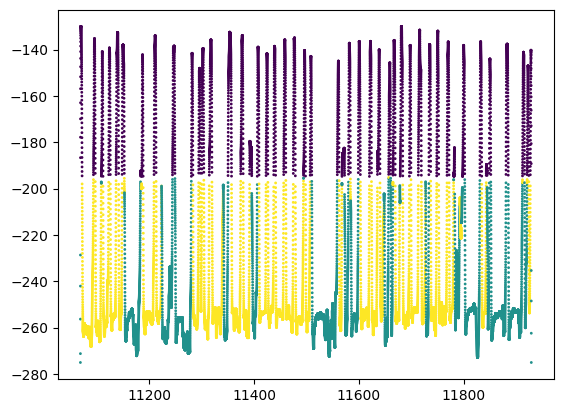

In [16]:
plt.scatter(stim['stimulus']['timestamp'][54373:80424],stim['stimulus']['linearpos'][54373:80424],  c=stim['stimulus']['armID'][54373:80424], s=1)

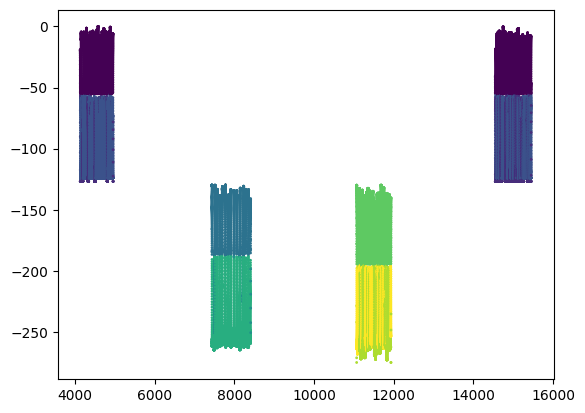

In [17]:
plt.scatter(stim['stimulus']['timestamp'],stim['stimulus']['linearpos'],  c=stim['stimulus']['armID'], s=1)

# preparing data

In [8]:
#run1 = (vel['lVel']['run1']['timestamp'][0], vel['lVel']['run1']['timestamp'][-1])

run3 = (vel['lVel']['run3']['timestamp'][0], vel['lVel']['run3']['timestamp'][-1])
run3

(11068.054411935254, 11929.419659935254)

In [10]:
pos_bw = 5  # cm, default spatial kernel bandwidth
amp_bw = 0.00004  # default spike amplitude kernel bandwidth
compression = 0.5 # kernel density compression Mahalanobis distance threshold

stim_sampling_frequency = 30.0  # Hz, sampling frequency of position tracking
speed_threshold = 15.0  # cm/s, only use data when animal runs faster than speed threshold for building encoding model

decode_bin = 0.2  # seconds, bin size for run decoding

In [11]:
# correction of labels
#run1 -1
#run2 -4
#run3 -7

In [12]:
stimulusarmID = [armID-7 for armID in sp['sp']['stimulusarmID']]

In [13]:
armID_stim = stim['stimulus']['armID']-7
armID_stim

array([-5., -5., -5., ..., -5., -5., -5.])

In [14]:
tt_amp = [resp[ix][:,:-1] for resp, ix in zip(sp['sp']['response'], sp['sp']['ix'])]
tt_time = [time[ix] for time, ix in zip(sp['sp']['timestamp'], sp['sp']['ix'])]
tt_pos = [np.concatenate([pos[:, None], ix[:, None]], axis=1) for pos, ix in zip(sp['sp']['stimuluslinpos'], stimulusarmID)]
tt_pos = [pos[ix] for pos, ix in zip(tt_pos, sp['sp']['ix'])]

speed = abs(veldata)
stimtime = stim['stimulus']['timestamp']
pos = np.concatenate([stim['stimulus']['linearpos'][:, None], armID_stim[:, None]], axis=1)

# prepraring spaces

In [18]:
# determine run epochs
with np.errstate(invalid="ignore"):  # get rid of annoying warning about NaNs
    run_epochs = fklab.segments.Segment.fromlogical(
        abs(speed[:]) > speed_threshold, stimtime
    )

In [19]:
# construct multi-dimensional euclidean space for spike amplitudes with default kernel bandwidth
spike_space = compressed_kde.EuclideanSpace(
    ["amp{0}".format(x) for x in range(4)], bandwidth=[amp_bw,] * 4
)

In [20]:
# x1 = np.linspace(0, -126.9, 30)
x3 = np.linspace(-130, -275, 30)
stim['stimulus']['linearpos'][54373:80424].max()

-130.0

In [21]:
lin_space = compressed_kde.EuclideanSpace(
    ['x'],      # list of labels for all dimensions
    kernel=compressed_kde.GaussianKernel(),  # desired kernel
    bandwidth=[5]     # list of bandwidths for all dimensions
)
lin_grid = lin_space.grid(
    [x3],  # list of coordinate vectors for all dimensions
)

cat_space = compressed_kde.CategoricalSpace(
    'arm',      # the name of the space
    ['1', '2', '3'] # a list of category labels
    )
cat_grid = cat_space.grid()

space = compressed_kde.MultiSpace([lin_space, cat_space])
grid = space.grid([lin_grid, cat_grid])

# Building the decoder

In [22]:
def decoder_build_factory(**kwargs):

    kwd = {
        "stimulus_space",
        "grid",
        "stimulus_duration",
        "compression",
        "stimulus",
        "stimulus_time",
        "event_time",
        "event_stimulus",
        "event_data",
        "event_space",
    }

    if not kwd.issubset(set(kwargs.keys())):
        raise ValueError("We are missing some keyword arguments")

    def fcn(epochs):

        # first create a Stimulus object that represents the stimulus probability density
        stim = decode.Stimulus(
            kwargs["stimulus_space"],
            kwargs["grid"],
            kwargs["stimulus_duration"],
            kwargs["compression"],
        )
        stim.add_stimuli(
            kwargs["stimulus"][epochs.contains(kwargs["stimulus_time"])[0]]
        )

        # then build the likelihoods for each of the sources (tetrodes)
        likelihoods = []
        for event_time, event_stimulus, event_data in zip(
            kwargs["event_time"], kwargs["event_stimulus"], kwargs["event_data"]
        ):
            selection = epochs.contains(event_time)[
                0
            ]  # select events within training epochs
            L = decode.PoissonLikelihood(kwargs["event_space"], stim)
            L.add_events(
                np.concatenate(
                    (event_data[selection], event_stimulus[selection]), axis=1
                )
            )
            likelihoods.append(L)

        # build decoder from likelihoods
        decoder = decode.Decoder(likelihoods, [])

        return decoder, likelihoods

    return fcn

In [23]:
# to build only one likelihood: tetrodes are concatenated to a list of lenght 1
event_time, event_stimulus, event_data = list([np.concatenate(tt_time)]), list([np.concatenate(tt_pos)]), list([np.concatenate(tt_amp)])    

data = dict(stimulus_space = space,
            grid = grid,
            stimulus_duration = 1./stim_sampling_frequency,
            compression = compression,
            stimulus = pos,
            stimulus_time = stimtime,
            event_time = event_time,  #tt_time,
            event_data = event_data,  #tt_amp,
            event_stimulus = event_stimulus,  #tt_pos,
            event_space = spike_space,
           )

build_decoder = decoder_build_factory(**data)

In [24]:
def data_build_factory(**kwargs):

    kwd = {"decode_bin", "event_time", "event_data"}

    if not kwd.issubset(set(kwargs.keys())):
        raise ValueError("We are missing some keyword arguments")

    def fcn(epochs):

        # split epochs into smaller bins for decoding
        decode_segments = epochs.split(size=kwargs["decode_bin"])
        bins = [
            decode_segments.contains(x, expand=True)[2] for x in kwargs["event_time"]
        ]

        # extract event data for each decoding bin
        data = [
            [
                np.zeros((0, x.shape[1]))
                if len(b[s]) == 1 and b[s][0] == -1
                else x[b[s], :]
                for x, b in zip(kwargs["event_data"], bins)
            ]
            for s in range(len(decode_segments))
        ]

        return decode_segments, data

    return fcn

In [25]:
data = dict(decode_bin=decode_bin, event_time=tt_time, event_data=tt_amp)

build_data = data_build_factory(**data)

In [26]:
#segemnts = [[4130.39275, 4295.22863439], [4295.22863439, 4460.06451877], [4460.06451877, 4624.90040316], [4624.90040316, 4789.73628755],[4789.73628755, 4954.57217194]]

In [27]:
np.linspace(run3[0] ,run3[1], 6)

array([11068.05441194, 11240.32746154, 11412.60051114, 11584.87356074,
       11757.14661034, 11929.41965994])

In [28]:
segemnts = [[11068.05441194,11240.32746154], [11240.32746154, 11412.60051114], [11412.60051114, 11584.87356074], [11584.87356074,11757.14661034], [11757.14661034, 11929.41965994]]

In [29]:
trials = fklab.segments.Segment(
   segemnts
)
ntrials = len(trials)

# Posterior

## here the kernel dies in the first iteration or it doen't even print the test_trial anymore or the result is wrong

In [ ]:
# create lists for collecting real position, estimates and errors
posteriors1 = []

# perform ntrial-fold cross validation
# i.e. each trial will be used for test data once and
# the others are used for training data

for test_trial in range(ntrials):
    print(test_trial)

    # set training epochs to all trials except the test trial
    training_epochs = run_epochs.intersection(
        trials[[trial for trial in range(ntrials) if trial != test_trial]]
    )

    # construct decoder for current training epochs
    decoder1, likelihoods = build_decoder(training_epochs)

    # test data during run maze arm runs for test trial only
    test_epochs = run_epochs.intersection(trials[test_trial])

    # extract event data for each time bin
    decode_segments, data = build_data(test_epochs)

    # perform decoding and concatenate posteriors
    posterior = [decoder1.decode(x, decode_bin, True) for x in data]
    posterior = np.vstack(posterior)
    posteriors1.append(posterior)

#     # compute MAP estimates
#     n, shape = posterior.shape[0], posterior.shape[1:]
#     max_posterior = np.unravel_index(
#         np.argmax(posterior.reshape((n, -1)), axis=1), shape
#     )
#     max_posterior = np.column_stack(max_posterior)
#     # max_posterior = np.unravel_index( np.argmax(posterior, axis=1), grid.shape )
#     pos_estimates.append(cat_grid.points()[max_posterior[:, 0]])
#     dir_estimates.append(max_posterior[:, 1])
    
#     # determine real stimulus values
#     pos_reals.append(linear_pos_interpolator(decode_segments.center))
#     dir_reals.append(linear_rd_interpolator(decode_segments.center))

    # compute errors
    # pos_errors.append(
    #     np.abs(
    #         maze["maze"]["shapes"]["track"]["shape"].distance(
    #             pos_estimates[-1], pos_reals[-1]
    #         )
    #     )
    # )
#     dir_errors.append(dir_estimates[-1] != dir_reals[-1])
    
# pos_estimates = np.concatenate(pos_estimates)
# pos_reals = np.concatenate(pos_reals)
# # pos_errors = np.concatenate(pos_errors)

# dir_estimates = np.concatenate(dir_estimates)
# dir_reals = np.concatenate(dir_reals)
# dir_errors = np.concatenate(dir_errors)

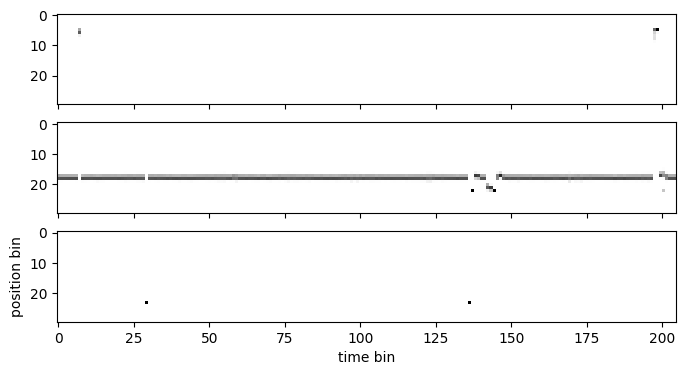

In [36]:
fig, ax = plt.subplots(3, 1, figsize=(15,4), sharex=True)
img = ax[0].imshow(posterior[:,:,0].T, cmap="gray_r")
img = ax[1].imshow(posterior[:,:,1].T, cmap="gray_r")
img = ax[2].imshow(posterior[:,:,2].T, cmap="gray_r")
ax[2].set(ylabel="position bin", xlabel="time bin")
#ax.set(ylabel="position bin", xlabel="time bin")
#plt.colorbar(img, label="posterior probability")
plt.savefig('fig/Yposterior', dpi=500, transparent=True)

## How it is supposed to look like (old plot from when I likelihoods separately)


In [52]:
posteriors1[0].shape

(205, 30, 3)

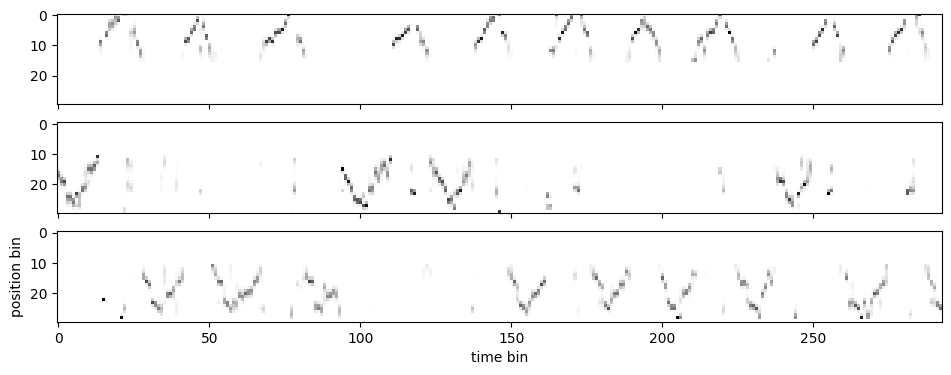

In [35]:
fig, ax = plt.subplots(3, 1, figsize=(15,4), sharex=True)
img = ax[0].imshow(posteriors[3][:,:,0].T, cmap="gray_r")
img = ax[1].imshow(posteriors[3][:,:,1].T, cmap="gray_r")
img = ax[2].imshow(posteriors[3][:,:,2].T, cmap="gray_r")
ax[2].set(ylabel="position bin", xlabel="time bin")
#ax.set(ylabel="position bin", xlabel="time bin")
#plt.colorbar(img, label="posterior probability")
plt.savefig('fig/Yposterior', dpi=500, transparent=True)

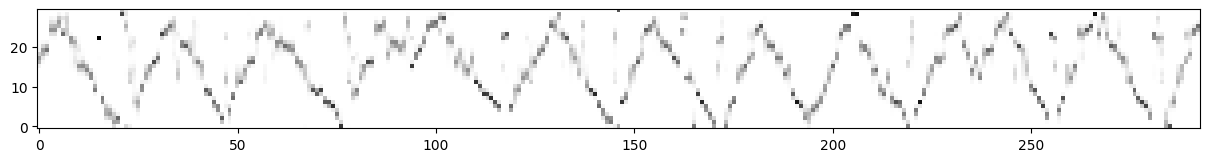

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))
img = ax.imshow(posteriors[3][:,:,0].T+posteriors[3][:,:,1].T+posteriors[3][:,:,2].T, cmap="gray_r", origin="lower")

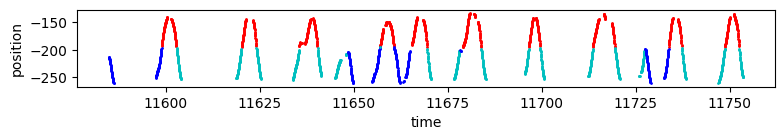

In [103]:
test_epochs = run_epochs.intersection(trials[3])

cdict = {0: 'red', 1: 'blue', 2: 'c'}
fig, ax = plt.subplots(figsize=(9,1))
for start, stop in zip(test_epochs.start, test_epochs.stop):
    IND = np.where((stim['stimulus']['timestamp']>start) & (stim['stimulus']['timestamp']<stop))[0]
    if len(IND)>2:
        group = armID_stim[IND[0]:IND[-1]].astype(int)
        for g in np.unique(group):
            ix = np.where(group == g)[0]
            ax.scatter(stim['stimulus']['timestamp'][IND[0]:IND[-1]][ix], stim['stimulus']['linearpos'][IND[0]:IND[-1]][ix], c = cdict[g], s = 1)
        # plt.scatter(stim['stimulus']['timestamp'][IND[0]:IND[-1]], stim['stimulus']['linearpos'][IND[0]:IND[-1]],  c=, s=1)
ax.set(ylabel="position", xlabel="time")
plt.savefig('fig/Ypos', dpi=500, transparent=True, bbox_inches='tight')

# getting likelihood

In [ ]:
poissonclass = decoder.likelihood(source,index) 
#source is the number of the electrode if you built a decoder with one likelihood per electrode, or 0 if you built a decoder with one likelihood. 
#index is the index of the stimulus space, or 0 if you only have one

likelihood = poissonclass.likelihood(events,duration) 
#events (array) is the data with the waveform features, duration (str) is the total time during which the events were observed

In [39]:
poissonclass = decoder.likelihood(1,0) 

In [ ]:
#likelihood = poissonclass.likelihood(data,decode_bin) 
L = [poissonclass.likelihood(x[0],decode_bin) for x in data]
#events (array) is the data with the waveform features, duration (float) is the total time during which the events were observed

## Alternatively: why not take likelihood from different sources and multiply it?

In [ ]:
Ls = []
for i in range(7):
    selection = trials[0].contains(tt_time[i])[0]
    # likelihood[i] of electrode i with data x[i] of electrode i
    L = [likelihoods[i].likelihood(x[i], decode_bin) for x in data]
    # L = likelihoods[i].likelihood(tt_amp[i][selection], decode_bin)
    Ls.append(L)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,4))
likelihood_m = np.prod(np.array(Ls), axis=0)
marginal_norm = likelihood_m.T / np.sum(likelihood_m.T, axis=0)
marginal_plot = np.log(marginal_norm)
fig = ax.imshow(marginal_norm, cmap="gray_r")
plt.colorbar(img, label="posterior probability")